In [1]:
'''
This notebook experiments with the tolerance parameter of the Douglas Peucker algorithm
to find the optimal parameter
'''

'\nThis notebook experiments with the tolerance parameter of the Douglas Peucker algorithm\nto find the optimal parameter\n'

In [2]:
import geopandas as gpd
import movingpandas as mpd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import sys
warnings.filterwarnings('ignore')

print("Geopandas has version {}".format(gpd.__version__))
print("Movingpandas has version {}".format(mpd.__version__))

Geopandas has version 0.13.2
Movingpandas has version 0.17.1


In [3]:
# read data from file
filenames = ['../data/processed/202204_points_stavanger_cleaned_200k.parquet',
             '../data/processed/202204_points_stavanger_cleaned_200k1.parquet',
             '../data/processed/202204_points_stavanger_cleaned_200k2.parquet']

In [4]:
# Douglas Peucker tolerance parameter list
tolerances = [1e-5, 2e-5, 5e-5, 1e-4, 2e-4, 5e-4, 1e-3, 2e-3, 5e-3, 0.01, 0.02, 0.05, 0.1]
retained_fractions = {}

for filename in filenames:
    gdf = gpd.read_parquet(filename)
    # convert to Trajectory Collection
    trajectories = mpd.TrajectoryCollection(gdf, traj_id_col='mmsi', obj_id_col='mmsi')
    print(f'Loaded dataset: {filename}')
    print(f'AIS messages: {len(gdf)}')
    print(f'Trajectories: {len(trajectories)}')
    n_points = []
    for tolerance in tolerances:
        simplified_trajectories = mpd.DouglasPeuckerGeneralizer(trajectories).generalize(tolerance=tolerance)
        n_points.append(len(simplified_trajectories.to_point_gdf()))
    n_points = np.array(n_points)
    retained_fractions[filename] = n_points / len(gdf)

Loaded dataset: ../data/processed/202204_points_stavanger_cleaned_200k.parquet
AIS messages: 192346
Trajectories: 249
Loaded dataset: ../data/processed/202204_points_stavanger_cleaned_200k1.parquet
AIS messages: 194684
Trajectories: 267
Loaded dataset: ../data/processed/202204_points_stavanger_cleaned_200k2.parquet
AIS messages: 194523
Trajectories: 248


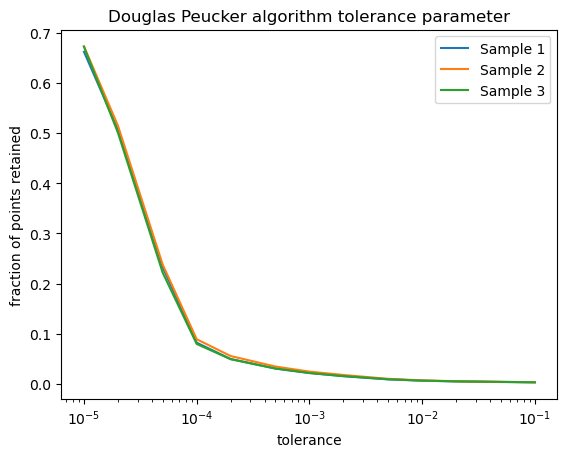

In [20]:
# plotting
plt.xscale('log')
for filename in filenames:
    plt.plot(tolerances, retained_fractions[filename])
plt.title('Douglas Peucker algorithm tolerance parameter')
plt.xlabel('tolerance')
plt.ylabel('fraction of points retained')
plt.legend(['Sample 1', 'Sample 2', 'Sample 3'])
plt.savefig('DP_tolerance_experiments.pdf')
plt.show()